Image batch shape: torch.Size([64, 3, 128, 128])
Parameters batch shape: torch.Size([64, 24])
Min: -26.7018, Max: 41.5652, Std: 7.3682, Median: -0.0354


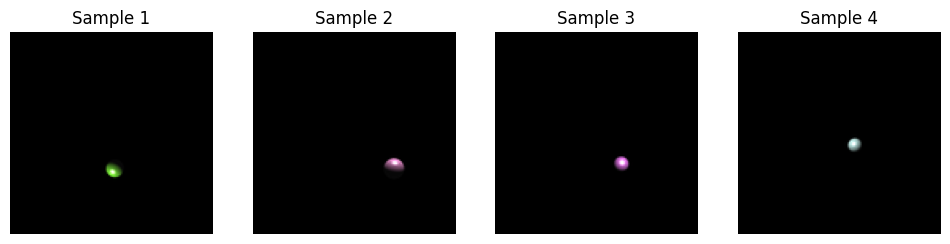

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

class FrameDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        
        self.camera_pos = [5.0, 5.0, 15.0]
        
        self.max_r = math.sqrt(25**2 + 25**2 + 35**2)  # Max radial distance
        self.r_range = [0, self.max_r]
        self.theta_range = [0, math.pi]
        self.phi_range = [-math.pi, math.pi]
        self.shininess_range = [3, 20]
        self.diffuse_range = [0, 1]
        
        self.image_files = [f"image_{str(i).zfill(4)}.png" for i in self.data['frame']]
        
        self.params_tensor = self.preprocess_data()
        
    def __len__(self):
        return len(self.data)
    
    def normalize(self, value, range_min, range_max):
        """Normalize value to [-1, 1]."""
        normalized = (value - range_min) / (range_max - range_min)
        return 2 * normalized - 1
    
    def get_orthonormal_basis(self, z_prime):
        """Compute orthonormal basis with z_prime as the z'-axis."""
        ref = [0, 0, 1]
        if abs(z_prime[2]) > 0.99:
            ref = [0, 1, 0]
        
        x_prime = [
            z_prime[1] * ref[2] - z_prime[2] * ref[1],
            z_prime[2] * ref[0] - z_prime[0] * ref[2],
            z_prime[0] * ref[1] - z_prime[1] * ref[0]
        ]
        x_norm = math.sqrt(sum(x * x for x in x_prime))
        x_prime = [x / x_norm for x in x_prime]
        
        y_prime = [
            z_prime[1] * x_prime[2] - z_prime[2] * x_prime[1],
            z_prime[2] * x_prime[0] - z_prime[0] * x_prime[2],
            z_prime[0] * x_prime[1] - z_prime[1] * x_prime[0]
        ]
        y_norm = math.sqrt(sum(y * y for y in y_prime))
        y_prime = [y / y_norm for y in y_prime]
        
        return x_prime, y_prime, z_prime
    
    def cartesian_to_spherical_lookat(self, x, y, z, lookat_vec):
        """Convert relative Cartesian coordinates to spherical coordinates aligned with lookat vector."""
        x_prime, y_prime, z_prime = self.get_orthonormal_basis(lookat_vec)
        
        x_new = x * x_prime[0] + y * x_prime[1] + z * x_prime[2]
        y_new = x * y_prime[0] + y * y_prime[1] + z * y_prime[2]
        z_new = x * z_prime[0] + y * z_prime[1] + z * z_prime[2]
        
        # Convert to spherical coordinates
        r = math.sqrt(x_new**2 + y_new**2 + z_new**2)
        theta = math.acos(z_new / r) if r > 0 else 0
        phi = math.atan2(y_new, x_new)
        
        return r, theta, phi
    
    def preprocess_data(self):
        """Preprocess all data to compute spherical coordinates and additional relative features."""
        params_list = []

        for idx in range(len(self.data)):
            row = self.data.iloc[idx]

            lookat_x_rel = row['lookat_target_x'] - self.camera_pos[0]
            lookat_y_rel = row['lookat_target_y'] - self.camera_pos[1]
            lookat_z_rel = row['lookat_target_z'] - self.camera_pos[2]
            lookat_norm = math.sqrt(lookat_x_rel**2 + lookat_y_rel**2 + lookat_z_rel**2)
            lookat_vec = (
                lookat_x_rel / lookat_norm if lookat_norm > 0 else 0,
                lookat_y_rel / lookat_norm if lookat_norm > 0 else 0,
                lookat_z_rel / lookat_norm if lookat_norm > 0 else 0
            )

            model_x_rel = row['model_translation_x'] - self.camera_pos[0]
            model_y_rel = row['model_translation_y'] - self.camera_pos[1]
            model_z_rel = row['model_translation_z'] - self.camera_pos[2]
            model_r, model_theta, model_phi = self.cartesian_to_spherical_lookat(
                model_x_rel, model_y_rel, model_z_rel, lookat_vec
            )

            light_x_rel = row['light_position_x'] - self.camera_pos[0]
            light_y_rel = row['light_position_y'] - self.camera_pos[1]
            light_z_rel = row['light_position_z'] - self.camera_pos[2]
            light_r, light_theta, light_phi = self.cartesian_to_spherical_lookat(
                light_x_rel, light_y_rel, light_z_rel, lookat_vec
            )

            light_to_model_vec = [
                light_x_rel - model_x_rel,
                light_y_rel - model_y_rel,
                light_z_rel - model_z_rel
            ]
            ltm_norm = math.sqrt(sum(x**2 for x in light_to_model_vec))
            light_to_model_unit = [x / ltm_norm if ltm_norm > 0 else 0 for x in light_to_model_vec]

            cos_view_light = sum(l * v for l, v in zip(light_to_model_unit, lookat_vec))
            ltm_normalized = self.normalize(ltm_norm, 0, self.max_r)

            x_prime, y_prime, z_prime = self.get_orthonormal_basis(lookat_vec)
            def rotate_to_view(x, y, z):
                return [
                    x * x_prime[0] + y * x_prime[1] + z * x_prime[2],
                    x * y_prime[0] + y * y_prime[1] + z * y_prime[2],
                    x * z_prime[0] + y * z_prime[1] + z * z_prime[2],
                ]
            model_view_xyz = rotate_to_view(model_x_rel, model_y_rel, model_z_rel)
            light_view_xyz = rotate_to_view(light_x_rel, light_y_rel, light_z_rel)

            params = [
                self.normalize(model_r, *self.r_range),
                self.normalize(model_theta, *self.theta_range),
                self.normalize(model_phi, *self.phi_range),
                self.normalize(light_r, *self.r_range),
                self.normalize(light_theta, *self.theta_range),
                self.normalize(light_phi, *self.phi_range),
                lookat_vec[0],
                lookat_vec[1],
                lookat_vec[2],
                self.normalize(row['material_diffuse_r'], *self.diffuse_range),
                self.normalize(row['material_diffuse_g'], *self.diffuse_range),
                self.normalize(row['material_diffuse_b'], *self.diffuse_range),
                self.normalize(row['material_shininess'], *self.shininess_range),
                ltm_normalized,
                cos_view_light,
                *light_to_model_unit,
                *model_view_xyz,
                *light_view_xyz
            ]

            params_list.append(params)

        return torch.tensor(params_list, dtype=torch.float32)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        params_tensor = self.params_tensor[idx]
        
        return image, params_tensor
    
def denormalize(img):
    """Denormalize images from [-1, 1] to [0, 1] for visualization."""
    return (img * 0.5) + 0.5

def get_data_loaders(csv_path, image_dir, batch_size=32, train_split=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    dataset = FrameDataset(csv_path, image_dir, transform=transform)
    
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

csv_path = "../output/frame_parameters.csv"
image_dir = "../output"
batch_size = 64

train_loader, val_loader = get_data_loaders(csv_path, image_dir, batch_size)

for images, params in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Parameters batch shape: {params.shape}")
    
    min_val = torch.min(params)
    max_val = torch.max(params)
    std_val = torch.std(params)
    median_val = torch.median(params)
    
    print(f"Min: {min_val.item():.4f}, Max: {max_val.item():.4f}, "
          f"Std: {std_val.item():.4f}, Median: {median_val.item():.4f}")
    
    num_samples = min(4, images.size(0))
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        img = denormalize(images[i])
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            img = img.permute(1, 2, 0)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img.squeeze().numpy(), cmap='gray' if img.shape[-1] == 1 else None)
        plt.axis('off')
        plt.title(f"Sample {i+1}")
    plt.show()
    break

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def visualize_progress(diffusion_model, val_loader, epoch, device, num_samples=5):
    diffusion_model.model.eval()

    images, params = next(iter(val_loader))
    images = images[:num_samples].to(device)
    params = params[:num_samples].to(device)
    
    generated_images = []
    with torch.no_grad():
        for i in tqdm(range(num_samples), desc="Generating images"):
            gen_img = diffusion_model.sample(params[i:i+1], img_shape=(3, 128, 128))
            generated_images.append(gen_img.squeeze(0))
    
    generated_images = torch.stack(generated_images)
    
    generated_images = denormalize(generated_images).cpu()
    ground_truth_images = denormalize(images).cpu()
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))
    fig.suptitle(f'Epoch {epoch}: Generated vs Ground Truth', fontsize=16)
    
    for i in range(num_samples):
        gen_img = generated_images[i].permute(1, 2, 0).numpy()
        axes[i, 0].imshow(gen_img)
        axes[i, 0].set_title('Generated')
        axes[i, 0].axis('off')
        
        gt_img = ground_truth_images[i].permute(1, 2, 0).numpy()
        axes[i, 1].imshow(gt_img)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show(block=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        batch, c, h, w = x.size()
        q = self.query(x).view(batch, -1, h * w).permute(0, 2, 1)
        k = self.key(x).view(batch, -1, h * w)
        v = self.value(x).view(batch, -1, h * w)
        attn = F.softmax(torch.bmm(q, k) / (c // 8) ** 0.5, dim=-1)
        out = torch.bmm(v, attn.permute(0, 2, 1)).view(batch, c, h, w)
        return x + self.gamma * out
    
class TransformerCondEmb(nn.Module):
    def __init__(self, cond_dim, base_channels, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(cond_dim, base_channels)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=base_channels, nhead=num_heads),
            num_layers=num_layers
        )
        self.out = nn.Linear(base_channels, base_channels * 4)
    
    def forward(self, cond):
        x = self.embedding(cond).unsqueeze(1)  # Add sequence dim
        x = self.transformer(x).squeeze(1)
        return self.out(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, cond_dim=24, base_channels=64):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.cond_dim = cond_dim
        self.base_channels = base_channels

        self.time_emb = nn.Sequential(
            nn.Linear(1, base_channels),
            nn.SiLU(),
            nn.Linear(base_channels, base_channels * 4)
        )
        
        self.cond_emb = TransformerCondEmb(cond_dim, base_channels)
        
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=base_channels),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, stride=2, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=base_channels * 2),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, stride=2, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=base_channels * 4),
            nn.ReLU()
        )
        
        self.mid = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=base_channels * 4),
            SelfAttention(base_channels * 4),
            nn.ReLU()
        )
        
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, stride=2, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=base_channels * 2),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels, 4, stride=2, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=base_channels),
            nn.ReLU()
        )
        self.dec3 = nn.Conv2d(base_channels * 2, in_channels, 3, padding=1)
        
    def forward(self, x, t, cond):
        t = t.unsqueeze(-1)
        t_emb = self.time_emb(t)
        
        cond_emb = self.cond_emb(cond)
        
        emb = t_emb + cond_emb
        
        h1 = self.enc1(x)
        h2 = self.enc2(h1)
        h3 = self.enc3(h2)
        
        h = self.mid(h3)
        h = h + emb.view(-1, h.shape[1], 1, 1)
        
        h = self.dec1(h)
        h = torch.cat([h, h2], dim=1)
        h = self.dec2(h)
        h = torch.cat([h, h1], dim=1)
        h = self.dec3(h)
        
        return h

class DiffusionModel:
    def __init__(self, model, timesteps=512, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.model = model.to(device)
        self.timesteps = timesteps
        self.device = device
        
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
    def add_noise(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bars[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def train_step(self, x, cond, optimizer):
        batch_size = x.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device)
        
        x_noisy, noise = self.add_noise(x, t)
        predicted_noise = self.model(x_noisy, t / self.timesteps, cond)
        
        loss = F.mse_loss(predicted_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    @torch.no_grad()
    def sample(self, cond, img_shape=(3, 128, 128)):
        x = torch.randn((1, *img_shape), device=self.device)
        cond = cond.to(device)
        
        for t in reversed(range(self.timesteps)):
            t_tensor = torch.full((1,), t / self.timesteps, device=self.device, dtype=torch.float32)
            predicted_noise = self.model(x, t_tensor, cond)
            
            alpha = self.alphas[t]
            alpha_bar = self.alpha_bars[t]
            beta = self.betas[t]
            
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * predicted_noise
            ) + torch.sqrt(beta) * noise
        
        print(x.min(), x.max())
        return torch.tanh(x)

def train_diffusion(train_loader, val_loader, epochs=100, device='cuda', vis_interval=10,
                    checkpoint_dir='checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    latest_ckpt = os.path.join(checkpoint_dir, 'latest.pt')
    best_ckpt = os.path.join(checkpoint_dir, 'best.pt')

    model = UNet(in_channels=3, cond_dim=24)
    diffusion = DiffusionModel(model, timesteps=1000, device=device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    if os.path.exists(latest_ckpt):
        checkpoint = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint.get('best_val_loss', best_val_loss)
        print(f"Resumed from epoch {start_epoch}")

    model.to(device)

    for epoch in range(start_epoch, epochs):
        model.train()
        train_loss = 0
        for images, params in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            params = params.to(device)
            loss = diffusion.train_step(images, params, optimizer)
            train_loss += loss
        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, params in val_loader:
                images = images.to(device)
                params = params.to(device)
                batch_size = images.shape[0]
                t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device)
                x_noisy, noise = diffusion.add_noise(images, t)
                predicted_noise = model(x_noisy, t / diffusion.timesteps, params)
                val_loss += F.mse_loss(predicted_noise, noise).item()
        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'epoch': epoch,
                        'best_val_loss': best_val_loss}, best_ckpt)
            print("Saved best model.")

        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss}, latest_ckpt)

        if (epoch + 1) % vis_interval == 0:
            print(f"Generating visualization for epoch {epoch+1}...")
            visualize_progress(diffusion, val_loader, epoch + 1, device, num_samples=5)

    return diffusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion = train_diffusion(train_loader, val_loader, epochs=200, device=device)

/home/idab/Dokumenty/GitHub/SIGK/04_rendering_neuralny/venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/200:   0%|          | 0/32 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (1024) must match the size of tensor b (64) at non-singleton dimension 1